### Estimation of Perceived Income Risks using SCE monthly data 

- The procedure decomposes perceived income growth to perceived risks 

In [2]:
import pandas as pd
import numpy as np
import numpy.ma as ma

## plot
import matplotlib.pyplot as plt
import seaborn as sb 

## estimation
from IncomeProcess import IMAProcess as ima

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

### Process SCE panel to get the data moments 


In [4]:
# monthly income growth 
IndSCE_raw = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta') 
IndSCE_columns = IndSCE_raw.columns
IndSCE_sub = IndSCE_raw[['date','userid','Q24_mean','Q24_var']]

In [5]:
#print(list(IndSCE_columns))

In [6]:
## multi index for a panel 

IndSCE_sub_panel = IndSCE_sub.pivot_table(values = ['Q24_mean','Q24_var'],
                                    index = ['date'],
                                    columns = ['userid'])
IndSCE_sub_panel.index = pd.to_datetime(IndSCE_sub_panel.index)

In [7]:
IndSCE_sub_panel.head()

Q24_mean                                                        \
userid     70000234 70000239 70000312 70000337 70000339 70000341 70003183   
date                                                                        
2013-06-01     0.93     3.46     5.84    -0.11     0.00    10.00     2.59   
2013-07-01      nan      nan     4.91     1.00      nan    10.00     0.88   
2013-08-01      nan     1.00     7.06     0.00      nan     6.00      nan   
2013-09-01      nan     1.19     6.07     0.00      nan     1.00      nan   
2013-10-01      nan      nan      nan     0.00      nan     4.00      nan   

                                       ...  Q24_var                    \
userid     70003231 70003242 70003252  ... 70107547 70107559 70107581   
date                                   ...                              
2013-06-01      nan     0.80     3.00  ...      nan      nan      nan   
2013-07-01     7.08      nan     2.19  ...      nan      nan      nan   
2013-08-01      nan      nan      nan  ...      nan      nan      nan   
2013-09-01      nan      nan     4.00  ...      nan      nan      nan   
2013-10-01      nan      nan      nan  ...      nan      nan      nan   

                                                                           
userid     70107591 70107599 70107604 70107633 70107638 70107650 70107651  
date                                                                       
2013-06-01      nan      nan      nan      nan      nan      nan      nan  
2013-07-01      nan      nan      nan      nan      nan      nan      nan  
2013-08-01      nan      nan      nan      nan      nan      nan      nan  
2013-09-01      nan      nan      nan      nan      nan      nan      nan  
2013-10-01      nan      nan      nan      nan      nan      nan      nan  

[5 rows x 18557 columns]

In [8]:
# get the expected growth and risks seperately 
IndSCE_mean = IndSCE_sub_panel['Q24_mean']
IndSCE_var = IndSCE_sub_panel['Q24_var']

In [9]:
Inc_diff_mat = np.asmatrix(np.array(IndSCE_mean)).T
Inc_diff_var_mat = np.asmatrix(np.array(IndSCE_var)).T

In [10]:
print('The number of month in the sample is ' + str(Inc_diff_mat.shape[1]))
print('The shape of diff matrix is ' + str(Inc_diff_mat.shape))
print('The shape of forward diff var matrix is ' + str(Inc_diff_var_mat.shape))

The number of month in the sample is 72
The shape of diff matrix is (9284, 72)
The shape of forward diff var matrix is (9273, 72)


In [11]:
## calculate data moments 
diff_cov = ma.cov(ma.masked_invalid(Inc_diff_mat), rowvar = False) 
## ma.cov computes the auto covariance matrix ignoring nan
diff_var_var = np.nanmean(Inc_diff_var_mat,axis = 0).flatten()

## volatility 
vols_mean = np.nanmean(Inc_diff_var_mat)
vols_cov = ma.cov(ma.masked_invalid(Inc_diff_var_mat), rowvar = False)


In [12]:
## plot autocovariance of expected income growth 
#sb.heatmap(diff_cov)

In [13]:
## Invoke estimation 

t_period = Inc_diff_mat.shape[1]

ima_est = ima(t = t_period,
              ma_coeffs = np.array([1])
             )
ima_est.n_agg = 12

vols_atv = np.empty(12)
for k in range(12):
    vols_atv[k] = np.mean([vols_cov[i,i+k] for i in range(t_period) if i< (t_period-k)])

data_moms_dct = {'Mean':np.zeros([t_period,t_period]),
                'Var':diff_cov}

data_vols_moms_dct = {'Mean':vols_mean,
                      'Var':vols_cov,
                     'ATV':vols_atv}

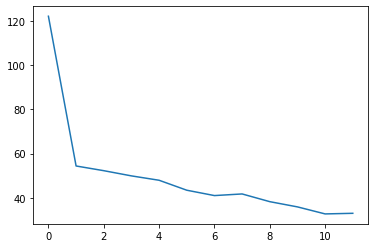

In [14]:
## autocovariance of different lags

plt.plot(data_vols_moms_dct['ATV'])

## Estimate stochastic volatility 


In [15]:
ima_est.GetDataMomentsVolsAgg(data_vols_moms_dct)
ima_est.EstimateSVolsParaAgg()

/Users/Myworld/Dropbox/IncExpProject/WorkingFolder/PythonCode/IncomeProcess.py:468: RuntimeWarning: overflow encountered in exp
  sigmas_theta[i,j+1] = np.sqrt(np.exp(rho*np.log(sigmas_theta[i,j]**2) + mu_draws[i,j+1]))
/Users/Myworld/Dropbox/IncExpProject/WorkingFolder/PythonCode/IncomeProcess.py:468: RuntimeWarning: divide by zero encountered in log
  sigmas_theta[i,j+1] = np.sqrt(np.exp(rho*np.log(sigmas_theta[i,j]**2) + mu_draws[i,j+1]))
/Users/Myworld/Dropbox/IncExpProject/WorkingFolder/PythonCode/IncomeProcess.py:492: RuntimeWarning: invalid value encountered in double_scalars
  vols_theta_this = sum([(n_agg-k-1)**2*self.hstep_sigma_theta(sigmas_theta_sim[i,j],k) for k in range(n_agg)])


Optimization terminated successfully.
         Current function value: 167.651388
         Iterations: 68
         Function evaluations: 132


array([-0.79853255,  0.0356289 ,  0.02641705])

In [16]:
ima_est.rho,ima_est.gamma, ima_est.sigma_eps = ima_est.para_svols_est_agg
ima_est.t = t_period
vols_sim = ima_est.SimulateSVols()
vols_agg_sim = ima_est.SimulateSVolsAgg()
vols_agg_sim_mom = ima_est.SimulateSVolsAggMoms()

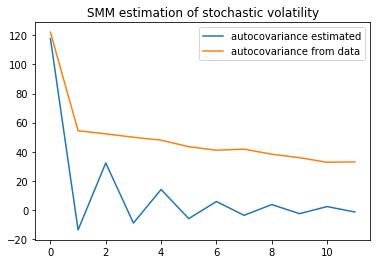

In [17]:
plt.title('SMM estimation of stochastic volatility')
plt.plot(vols_agg_sim_mom['ATV'],
         label = 'autocovariance estimated')
plt.plot(data_vols_moms_dct['ATV'].T,
         label = 'autocovariance from data')
plt.legend(loc = 1)

In [18]:
print('average volatility from estimate is ' + str(vols_agg_sim_mom['Mean']))
print('average volatility from data is ' + str(data_vols_moms_dct['Mean']))

average volatility from estimate is 94.26462553711919
average volatility from data is 5.500423407873594


## Using first moments 

In [30]:
ima_est.GetDataMomentsAgg(data_moms_dct)
agg_est = ima_est.EstimateParaAgg(method='Nelder-Mead')

         Current function value: 75.005838
         Iterations: 1
         Function evaluations: 124
         Gradient evaluations: 28


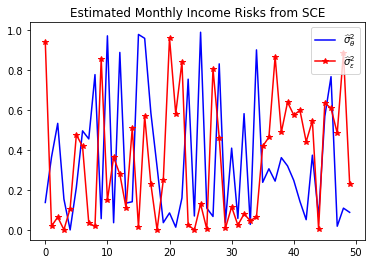

In [32]:
## plot the estimation 

plt.plot(ima_est.para_est_agg[1][0]**2,'b-',label=r'$\widehat\sigma^2_{\theta}$')
plt.plot(ima_est.para_est_agg[1][1]**2,'r*-',label=r'$\widehat\sigma^2_{\epsilon}$')
plt.title('Estimated Monthly Income Risks from SCE')
plt.legend(loc=0)